### Use `RGBD` camera

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
# from pyntcloud import PyntCloud
import sys
sys.path.append('../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse `UR5e` with `RG2` gripper

In [76]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_d435i_obj_realworld.xml'
# xml_path = '../../asset/ur5e/scene_ur5e_rg2_d435i_vbm.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)

obj_cylinder_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_cylinder"))]
obj_box_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_box"))]
obj_glass_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]

n_cylinder_obj = 3 # len(obj_cylinder_names)
n_box_obj = 3 # len(obj_box_names)
n_glass_obj = 3 # len(obj_glass_names)

# Place objects
env.place_objects(n_obj=3, obj_names=obj_cylinder_names, x_range=[0.65, 0.95], y_range=[-0.30, 0.30], COLORS=True, VERBOSE=True)
# env.place_objects(n_obj=3, obj_names=obj_box_names, COLORS=True, VERBOSE=True) 
env.place_objects(n_obj=3, obj_names=obj_glass_names, COLORS=False, VERBOSE=True)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([0.38+0.6,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])
env.model.body('base').pos = np.array([0.18,0,0.79])


print ("Ready.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[60]
n_geom:[62]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'front_object_table', 'right_object_table', 'left_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cylinder_08']
n_body:[31]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'd435i', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle

### Render

In [77]:
q_init = np.array([-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105])

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])
# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

stepsize = 2.0
render_every = 1
th = 5*np.pi/180.0
err_th = 1e-2
repulse = 15
eps = 0.1

# Straight pose
DO_RENDER = True
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_00 = env.solve_ik_repel(
    body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
    q_init=q_init, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every, eps = eps, repulse = repulse)

q_prepose_00 = env.solve_ik_repel(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every, eps = eps, repulse = repulse)

# 30 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_30 = env.solve_ik_repel(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every, eps = eps, repulse = repulse)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_60 = env.solve_ik_repel(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every, eps = eps, repulse = repulse)

env.close_viewer()
print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))


IK done.
q_traj's L:[12] time_max:[0.03]sec


In [78]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=[0,1,2,3,4,5])
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    q = np.append(q_traj[tick,:],1.0) # open gripper
    env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        R_tcp = R_tcp @ rpy2r(np.radians([-180,0,90]))
        env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
                label=f'TCP Position: {p_tcp}')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=None,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # Save PCD
        pcd_tick += 1
        # for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render(render_every=1)
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

Pressed ESC
Quitting.
Done. Tick:[402] Time:[0.80]sec


### Check current egocentric view

rgb_img:(800, 1200, 3), depth_img:(800, 1200), pcd:(960000, 3), xyz_img:(800, 1200, 3)


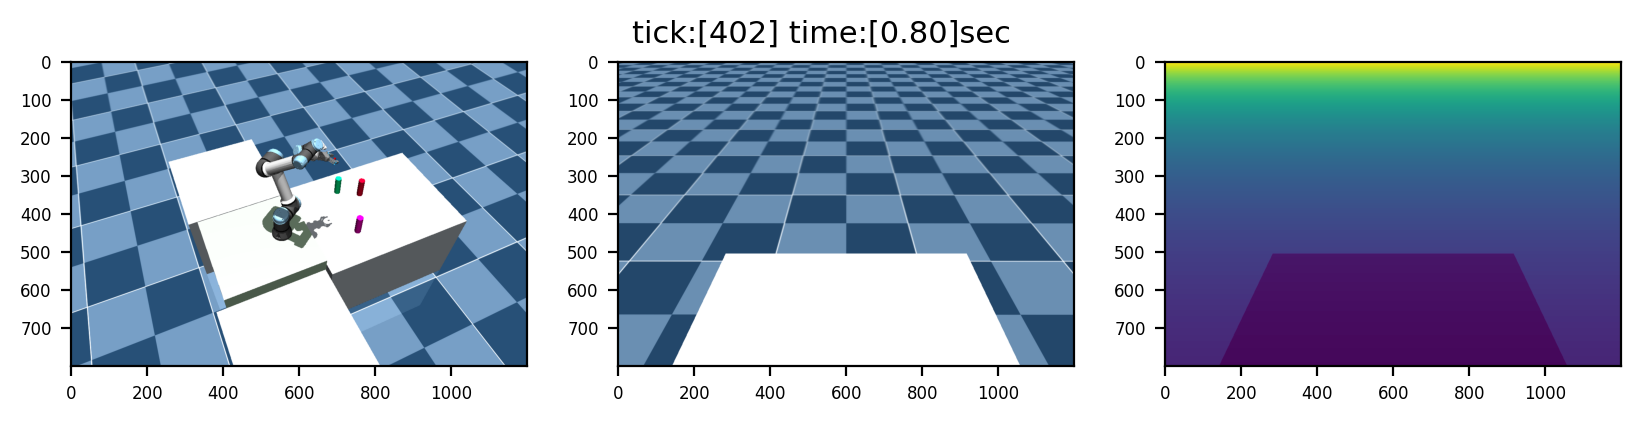

In [79]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Get egocentric view
rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
    p_ego=p_ego,p_trgt=p_trgt,rsz_rate=None,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
# Print
print ("rgb_img:%s, depth_img:%s, pcd:%s, xyz_img:%s"%
       (rgb_img.shape,depth_img.shape,pcd.shape,xyz_img.shape))
# Plot
fig,axs = plt.subplots(1,3,figsize=(10,2))
scene_img = env.grab_image()
axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
plt.subplots_adjust(wspace=0.2); plt.show()

# Close viewer
env.close_viewer()

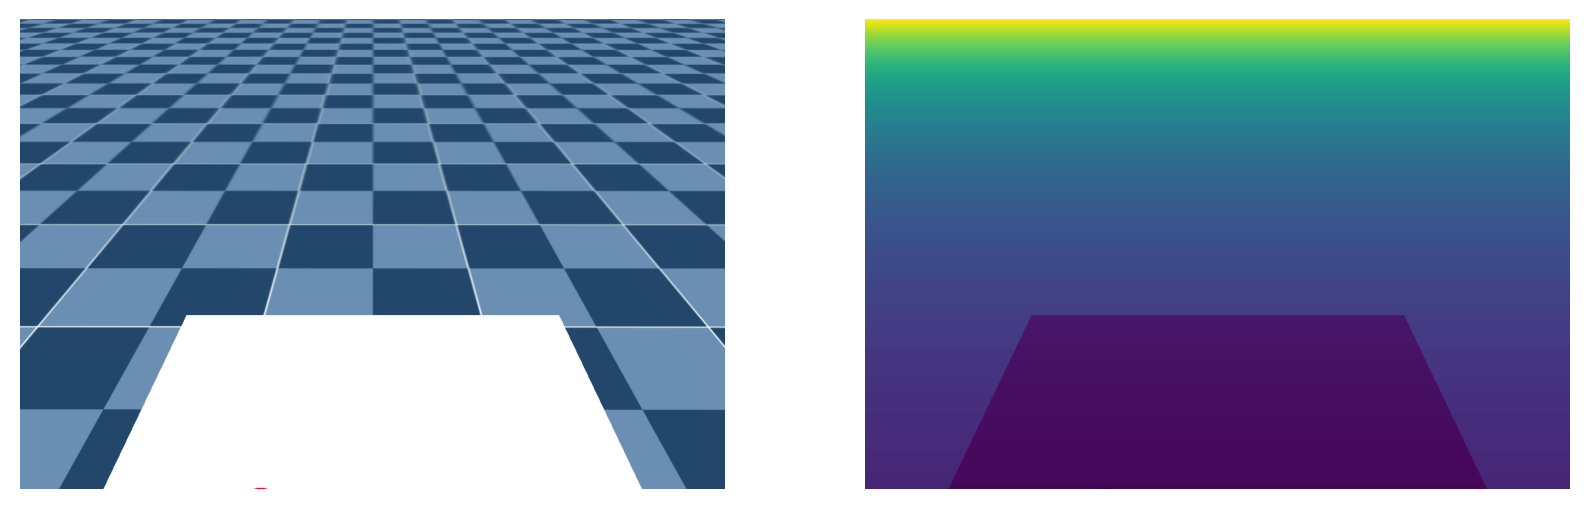

In [80]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_img)
plt.axis('off')
plt.show()

### Manually specify Grasp-pose

#### Grasp: Forward

In [81]:
from transforms3d import affines, euler, quaternions
from utils.util import pr2t, r2quat

grasped_obj_id = env.model.body('obj_cylinder_01').id

grasped_obj_model = env.model.body(grasped_obj_id)
grasped_obj_data = env.data.body(grasped_obj_id)

grasped_obj_qpos_adr = env.model.joint(
    grasped_obj_model.jntadr[0]
).qposadr[0]
grasp_obj_position = grasped_obj_data.xpos.copy()
grasp_obj_position[2] += 0.07
# grasp_obj_orientation = r2quat(grasped_obj_data.xmat.copy().reshape(3, 3))
grasp_obj_orientation = grasped_obj_data.xmat.copy().reshape(3, 3)
grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-180,0,90]))
grasp_obj_pose = pr2t(grasp_obj_position, grasp_obj_orientation)

eef_position = env.get_p_body('tcp_link')
# eef_orientation = r2quat(env.get_R_body('tcp_link'))
eef_orientation = env.get_R_body('tcp_link')
# eef_orientation = eef_orientation @ rpy2r(np.radians([-180,0,90]))
eef_pose = pr2t(eef_position, eef_orientation)

result_ = np.linalg.inv(eef_pose) @ grasp_obj_pose

In [82]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])

q_ik = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=grasp_obj_pose[:3,3],R_trgt=grasp_obj_pose[:3,:3],
    IK_P=True,IK_R=True, q_init=np.array(init_ur_q),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1.5, render_every=1.0, eps = 0.1, repulse = 10)

# Close viewer
env.close_viewer()
print ("Done.")

print(f"Solved joint q values: {q_ik}")

Done.
Solved joint q values: [-2.59 -2.37  4.47  4.19 -1.01 -6.28]


#### Grasp: Up-right

In [83]:
from transforms3d import affines, euler, quaternions
from utils.util import pr2t, r2quat

grasped_obj_id = env.model.body('obj_cylinder_01').id

grasped_obj_model = env.model.body(grasped_obj_id)
grasped_obj_data = env.data.body(grasped_obj_id)

grasped_obj_qpos_adr = env.model.joint(
    grasped_obj_model.jntadr[0]
).qposadr[0]
grasp_obj_position = grasped_obj_data.xpos.copy()
grasp_obj_position[2] += 0.08
# grasp_obj_orientation = r2quat(grasped_obj_data.xmat.copy().reshape(3, 3))
grasp_obj_orientation = grasped_obj_data.xmat.copy().reshape(3, 3)
grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-90,0,90]))
grasp_obj_pose = pr2t(grasp_obj_position, grasp_obj_orientation)

eef_position = env.get_p_body('tcp_link')
# eef_orientation = r2quat(env.get_R_body('tcp_link'))
eef_orientation = env.get_R_body('tcp_link')
# eef_orientation = eef_orientation @ rpy2r(np.radians([-180,0,90]))
eef_pose = pr2t(eef_position, eef_orientation)

result_ = np.linalg.inv(eef_pose) @ grasp_obj_pose

env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])

q_ik = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=grasp_obj_pose[:3,3],R_trgt=grasp_obj_pose[:3,:3],
    IK_P=True,IK_R=True, q_init=np.array(init_ur_q),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1.5, render_every=1.0, eps = 0.1, repulse = 10)

# Close viewer
env.close_viewer()
print ("Done.")

print(f"Solved joint q values: {q_ik}")

Done.
Solved joint q values: [-2.78 -3.36  1.08  3.85  1.57 -2.78]


##### Grasp: Side (Right)

In [84]:
from transforms3d import affines, euler, quaternions
from utils.util import pr2t, r2quat

grasped_obj_id = env.model.body('obj_cylinder_01').id

grasped_obj_model = env.model.body(grasped_obj_id)
grasped_obj_data = env.data.body(grasped_obj_id)

grasped_obj_qpos_adr = env.model.joint(
    grasped_obj_model.jntadr[0]
).qposadr[0]
grasp_obj_position = grasped_obj_data.xpos.copy()
grasp_obj_position[1] -= 0.10
grasp_obj_position[2] += 0.07
# grasp_obj_orientation = r2quat(grasped_obj_data.xmat.copy().reshape(3, 3))
grasp_obj_orientation = grasped_obj_data.xmat.copy().reshape(3, 3)
grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-180,0,180]))
grasp_obj_pose = pr2t(grasp_obj_position, grasp_obj_orientation)

eef_position = env.get_p_body('tcp_link')
# eef_orientation = r2quat(env.get_R_body('tcp_link'))
eef_orientation = env.get_R_body('tcp_link')
# eef_orientation = eef_orientation @ rpy2r(np.radians([-180,0,90]))
eef_pose = pr2t(eef_position, eef_orientation)

result_ = np.linalg.inv(eef_pose) @ grasp_obj_pose

env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])

q_ik = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=grasp_obj_pose[:3,3],R_trgt=grasp_obj_pose[:3,:3],
    IK_P=True,IK_R=True, q_init=np.array(init_ur_q),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1.5, render_every=1.0, eps = 0.1, repulse = 15)

# Close viewer
env.close_viewer()
print ("Done.")

print(f"Solved joint q values: {q_ik}")

Done.
Solved joint q values: [-0.45 -0.3   0.55  6.03 -0.45 -6.28]


##### Grasp: Side (Left)

In [85]:
from transforms3d import affines, euler, quaternions
from utils.util import pr2t, r2quat

grasped_obj_id = env.model.body('obj_cylinder_01').id

grasped_obj_model = env.model.body(grasped_obj_id)
grasped_obj_data = env.data.body(grasped_obj_id)

grasped_obj_qpos_adr = env.model.joint(
    grasped_obj_model.jntadr[0]
).qposadr[0]
grasp_obj_position = grasped_obj_data.xpos.copy()
grasp_obj_position[1] += 0.12
grasp_obj_position[2] += 0.07
# grasp_obj_orientation = r2quat(grasped_obj_data.xmat.copy().reshape(3, 3))
grasp_obj_orientation = grasped_obj_data.xmat.copy().reshape(3, 3)
grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-180,0,0]))
grasp_obj_pose = pr2t(grasp_obj_position, grasp_obj_orientation)

eef_position = env.get_p_body('tcp_link')
# eef_orientation = r2quat(env.get_R_body('tcp_link'))
eef_orientation = env.get_R_body('tcp_link')
# eef_orientation = eef_orientation @ rpy2r(np.radians([-180,0,90]))
eef_pose = pr2t(eef_position, eef_orientation)

result_ = np.linalg.inv(eef_pose) @ grasp_obj_pose

env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])

q_ik = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=grasp_obj_pose[:3,3],R_trgt=grasp_obj_pose[:3,:3],
    IK_P=True,IK_R=True, q_init=np.array(init_ur_q),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1.5, render_every=1.0, eps = 0.1, repulse = 15)

# Close viewer
env.close_viewer()
print ("Done.")

print(f"Solved joint q values: {q_ik}")

Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

### Get grasp pose from Primitive grasp poses

In [86]:
from utils.util import pr2t

def softmax(x):
    # Subtract max(x) to compute the softmax in a numerically stable way
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def get_grasp_pose_primitive(obj_name, grasp_pose=None, dist_orientation="geodesic"):
    tcp_position = env.get_p_body('tcp_link')
    tcp_orientation = rpy2r(np.radians([0,0,0])) @ rpy2r(np.radians([-180,0,90]))
    grasp_obj_position = env.get_p_body(obj_name)
    grasp_obj_orientation = env.get_R_body(obj_name)
    if grasp_pose == "upright":
        grasp_obj_position[2] += 0.10
        grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-90,0,90]))
    elif grasp_pose == "right":
        grasp_obj_position[1] -= 0.10
        grasp_obj_position[2] += 0.02
        grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-180,0,180]))
    elif grasp_pose == "left":
        grasp_obj_position[1] += 0.12
        grasp_obj_position[2] += 0.02
        grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-180,0,0]))
    elif grasp_pose == "forward":
        grasp_obj_position[0] -= 0.02
        grasp_obj_position[2] += 0.02
        grasp_obj_orientation = grasp_obj_orientation @ rpy2r(np.radians([-180,0,90]))
    else:   # Randomly sample grasp pose based on distance [Euclidean + Orientation]
        grasp_pose_primitive = ["upright", "right", "left", "forward"]
        grasp_obj_positions = []
        grasp_obj_orientations = []
        grasp_orientation_dists = []
        for grasp_pose_prim in grasp_pose_primitive:
            grasp_obj_pose = get_grasp_pose_primitive(obj_name, grasp_pose_prim)
            grasp_obj_positions.append(grasp_obj_pose[:3, 3])
            grasp_obj_orientations.append(grasp_obj_pose[:3, :3])
        grasp_dist = grasp_obj_positions - tcp_position
        # Calculate distances between orientations
        for grasp_obj_orientation_ in grasp_obj_orientations:
            if dist_orientation == "geodesic":
                trace_product = np.trace(np.dot(tcp_orientation.T, grasp_obj_orientation_))
                grasp_orientation_dist = np.arccos((trace_product - 1) / 2)
            elif dist_orientation == "frobenius":
                grasp_orientation_dist = np.linalg.norm(tcp_orientation - grasp_obj_orientation_, 'fro')
            grasp_orientation_dists.append(grasp_orientation_dist)
        grasp_orientation_dists = np.array(grasp_orientation_dists)
        grasp_dist = np.linalg.norm(grasp_dist, axis=1)
        grasp_weight = 1 / (grasp_dist + grasp_orientation_dists)
        grasp_pose = np.random.choice(grasp_pose_primitive, p=grasp_weight / np.sum(grasp_weight))
        print(f"grasp_pose: {grasp_pose}, grasp_weight: {grasp_weight}")
        grasp_obj_pose = get_grasp_pose_primitive(obj_name, grasp_pose)
        return grasp_obj_pose

    grasp_obj_pose = pr2t(grasp_obj_position, grasp_obj_orientation)

    return grasp_obj_pose

In [87]:
grasp_obj_pose = get_grasp_pose_primitive(obj_name="obj_cylinder_01", grasp_pose=None, dist_orientation="geodesic")

env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])

q_ik = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=grasp_obj_pose[:3,3],R_trgt=grasp_obj_pose[:3,:3],
    IK_P=True,IK_R=True, q_init=np.array(init_ur_q),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1.0, w_weight=0.5, render_every=1.0, eps = 0.3, repulse = 15, VERBOSE=False)

print(f"Solved joint q values: {q_ik}")
# Close viewer
env.close_viewer()
print ("Done.")


grasp_pose: forward, grasp_weight: [ 0.6   0.57  0.59 10.06]
Solved joint q values: [ 0.03 -0.84  1.88 -1.05  1.6  -0.  ]
Done.


In [88]:
q_ik

array([ 0.03, -0.84,  1.88, -1.05,  1.6 , -0.  ])

### Execute it !

In [89]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
q_init_upright = np.array([0,-np.pi/2,0,0,np.pi/2,0])
env.forward(q=q_init_upright, joint_idxs=env.idxs_forward)
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    # Step
    if np.linalg.norm(env.get_p_body('tcp_link')-grasp_obj_pose[:3,3]) < 1e-2:
        q = np.append(q_ik,0.0) # close gripper
    else:
        q = np.append(q_ik,1.0) # open gripper
    env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])

    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')

        env.render(render_every=1)
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

Pressed ESC
Quitting.
Done. Tick:[4177] Time:[8.35]sec


In [56]:
env.get_p_body('tcp_link')-grasp_obj_pose[:3,3]

array([-0.  , -0.  , -0.01])

## Detect Grasp pose

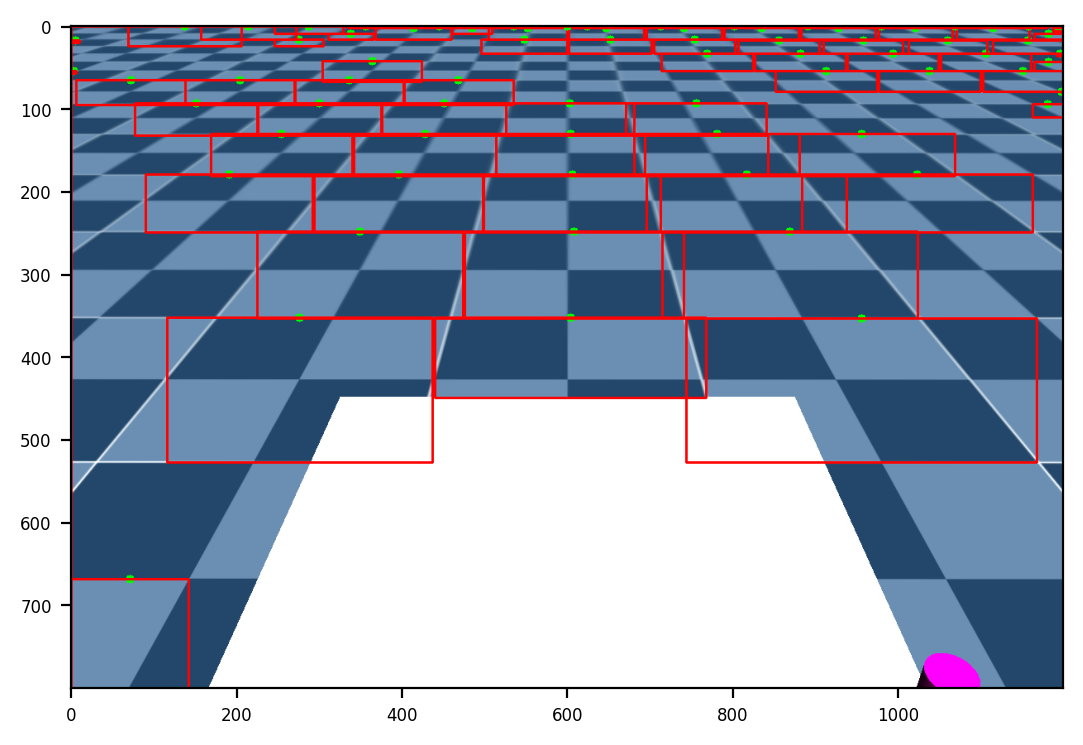

In [ ]:
import cv2
import numpy as np

def get_grasp_pose(image_array):
    # Copy the array to avoid modifying the original image
    image = np.copy(image_array)
    # Convert image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to get binary image
    _, binary_image = cv2.threshold(grayscale_image, 128, 255, cv2.THRESH_BINARY)
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through contours and find top points
    for contour in contours:
        # Get the bounding rect
        x, y, w, h = cv2.boundingRect(contour)
        # Top point is the first point in the bounding rect
        top_point = (x + w//2, y)
        # Draw circle for grasp point
        cv2.circle(image, top_point, 5, (0, 255, 0), -1)
        # Draw rectangle for object
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Show the image
    plt.imshow(image)
    plt.show()
    
# Test the function
get_grasp_pose(rgb_img)
